In [1]:
import os
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)

# Water model development

The goal of this notebook is develop and improve the water model.

## Data

In [2]:
from data_utils.database import select_dataset
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.express as px

from data_utils.utils import data_dict_from_df_tables, get_X_y_from_data
from ggmodel.validation import score_model, plot_diagnostic

plt.style.use('ggplot')

def prepare_water_model_data():

    # Select dataset
    df_tables = ["aquastat", 'worldbank', 'evapotranspiration', 'cropcalendar', 'efficientwater', 'sarahcrops']

    df_dictionnary = {df_table: select_dataset(df_table) for df_table in df_tables}

    # Preprocess some datasets
    df_dictionnary['cropcalendar'] = df_dictionnary['cropcalendar'].drop(columns=['Year'])
    df_dictionnary['aquastat'] = df_dictionnary['aquastat'][~df_dictionnary['aquastat'].Variable.isin(['CI', 'TC', 'ICA', 'AIR'])]
    df_dictionnary['sarahcrops'] = df_dictionnary['sarahcrops'][~df_dictionnary['sarahcrops'].Variable.isin(['ICA', 'CI'])]


    # Convert to model readable datadict
    data_dict = data_dict_from_df_tables([df for _, df in df_dictionnary.items()])

    ISOs = df_dictionnary['aquastat'].ISO.unique()
    
    # Impute missing values
    def preprocess_dict_item(key, value):
        mux = pd.MultiIndex.from_product([ISOs, range(2000, 2020)],
                                     names=['ISO', 'Year'])

        if key in ['ICA', 'Kc']:
            return value
        else:
            return (
                  value.reindex(mux)
                      .groupby(level='ISO')
                      .fillna(method='ffill')
                      .groupby(level='ISO')
                      .fillna(method='bfill')
                      .fillna(0))


    data_dict = {k: preprocess_dict_item(k, v).sort_index() for k, v in data_dict.items()} # comment here for raw data

    return data_dict

data_dict = prepare_water_model_data()

## Model

In [3]:
from ggmodel.graphmodel import GraphModel, concatenate_graph_specs
import numpy as np

# Conversions
height_rice = 0.2  # meter height of rice
ha_to_m2 = 1e4  # * 1e3 
mm_to_m = 1e-2  # 1e-3 TO CHECK
mmyear_to_m3year = 1e-2 #  from mm/year to m3/year as 1mm = 10m3/ha \n",

IWW_nodes = {'Kc': {'type': 'parameter', 'unit': '1', 'name': 'Crop Factor'},
             'ICA': {'type': 'input', 'unit':'1000 ha', 'name': 'Cropland area actually irrigated'},
             'CI': {'type': 'variable',
                    'unit': '1',
                    'name': 'Cropping Intensity',
                    'computation': lambda ICA, AIR, **kwargs: ICA / AIR
                    },
             'ETo': {'type': 'input', 'unit': 'mm/year', 'name': 'Evapotranspiration'},
             'ETc': {'type': 'variable',
                     'name': 'Potential Crop Evaporation Vector',
                     'unit': 'mm/year',
                     'computation': lambda Kc, CI, ETo, **kwargs: (Kc * CI * ETo).groupby(level=['ISO']).sum()
                     },
             'ETa': {'type': 'input',
                     'unit': 'mm/year',
                     'name': 'Actual Evapotranspiration'},
             'ICU': {'type': 'variable',
                     'name': 'Irrigation Consumptive Use',
                     'unit': 'mm/year',
                     'computation': lambda ETc, ETa, **kwargs: abs(ETc - ETa) # bug to fix
                     },
             'AIR': {'type': 'parameter',
                     'unit': '1000 ha',
                     'name': 'Agriculture area actually irrigated'},
             'Arice': {'type': 'parameter',
                       'unit': '1000 ha',
                       'name': 'Area of Rice Paddy Irrigation'},
             'WRR': {'type': 'parameter', 'name': 'Water Requirement Ratio', 'unit': '1'},
             'IWR': {'type': 'variable',
                     'name': ' Irrigation Water Requirement',
                     'unit': '1e9 m3/year',
                     'computation': lambda ICU, AIR, Arice, **kwargs: 1e-9 * ha_to_m2 * mmyear_to_m3year * ((ICU * AIR) + Arice * height_rice)
                     },
             'IWW': {'type': 'variable',
                     'name': ' Irrigation Water Withdrawal',
                     'unit': '1e9 m3/year',
                     'computation': lambda IWR, WRR, **kwargs: IWR / WRR * 1e2
                     },
             'AWU': {'type': 'variable', 'unit': '1e9 m3/year',
                     'name': 'Agricultural Water Withdrawal',
                     'computation': lambda IWW, **kwargs: IWW
                     },
             }


def model_MWU(GDPC, WP, Pop):
    '''Find alternative to hard coding,
    also find way to link the regression data to those coefficient to improve reproducability
    '''
    return np.exp(-0.9522 - 0.3174 * np.log(WP) + 0.5918827 * np.log(GDPC) + 0.9859812 * np.log(Pop)) * 1e-9


MWU_nodes = {'WP': {'type': 'input', 'name': 'Water Price', 'unit': '$/15m3'},
             'GDPC': {'type': 'parameter', 'name': 'GDP per capita', 'unit': '$'},
             'Pop': {'type': 'parameter', 'name': 'Population', 'unit': 'capita'},
             'MWU': {'type': 'variable',
                     'name': 'Municipal Water Withdrawal',
                     'unit': '1e9 m3/year',
                     'computation': lambda GDPC, WP, Pop, **kwargs: model_MWU(GDPC, WP, Pop)
                     }
             }
EW1_nodes = {'IWU': {'type': 'parameter',
                     'name': 'Industrial Water Withdrawal',
                     'unit': '1e9 m3/year'},
             'ICA': {'type': 'input',
                     'unit': '1000 ha',
                     'name': 'Cropland area actually irrigated'},
             'MWU': {'type': 'input',
                     'name': 'Municipal Water Withdrawal',
                     'unit': '1e9 m3/year'},
             'AWU': {'type': 'input',
                     'name': 'Agricultural Water Withdrawal',
                     'unit': '1e9 m3/year'},
             'TWW': {'type': 'variable',
                     'name': 'Total Water Withdrawal',
                     'unit': '1e9 m3/year',
                     'computation': lambda AWU, IWU, MWU, **kwargs: AWU + IWU + MWU
                     },
             'AGVA': {'type': 'input',
                      'name': 'Agricultural Gross Value Added',
                      'unit': '$',
                      },

             'CL': {'type': 'parameter',
                    'unit': '1000 ha',
                    'name': 'Cropland'},
             'PAIR': {'type': 'variable',
                      'name': 'Proportion of Irrigated Cropland',
                      'unit': '1',
                      'computation': lambda ICA, CL, **kwargs: ICA.groupby(level=['ISO']).sum() / CL
                      },
             'Cr': {'type': 'variable',
                    'name': 'Corrective coefficient',
                    'unit': '1',
                    'computation': lambda PAIR, **kwargs: 1 / (1 + (PAIR / (1 - PAIR) * 0.375))
                    },

             'IGVA': {'type': 'parameter',
                      'name': 'Industrial Gross Value Added',
                      'unit': '$'},

             'SGVA': {'type': 'parameter',
                      'name': 'Service Sector Gross Value Added',
                      'unit': '$'},
             'EW1': {'type': 'output',
                     'name': 'Water Use Efficiency',
                     'unit': '$/(m3/year)',
                     'computation': lambda TWW, AGVA, IGVA, SGVA, Cr, **kwargs: (AGVA * (1 - Cr) + IGVA + SGVA) / (TWW * 1e9)
                     },
             }

EW2_nodes = {
    'IRWR': {'type': 'input',
                     'name': 'Internal Renewable Water Resources',
                     'unit': 'm3/year'},
    'ERWR': {'type': 'input',
             'unit': 'm3/year',
             'name': 'External Renewable Water Resources'},
    'TRF': {'type': 'variable',
            'name': 'Total Renewable Freshwater',
            'unit': 'm3/year',
            'computation': lambda IRWR, ERWR, **kwargs: IRWR + ERWR
            },
    'DW': {'type': 'parameter', 'unit': 'm3/year', 'name': 'Desalination Water'},
    'TW': {'type': 'parameter', 'unit': 'm3/year', 'name': 'Treated Wastewater'},
    'TNCW': {'type': 'variable',
             'name': 'Total Non Conventional Water',
             'unit': 'm3/year',
             'computation': lambda DW, TW, **kwargs: DW + TW
             },
    'TFA': {'type': 'variable',
            'name': 'Total Freshwater Available',
            'unit': 'm3/year',
            'computation': lambda TRF, TNCW, **kwargs: TRF + TNCW
            },
    'TWW': {'type': 'input', 'unit': '1e9 m3/year', 'name': 'Total Water Withdrawal'},
    'EFR': {'type': 'parameter',
            'unit': 'm3/year',
            'name': 'Environmental Flow Requirement'},
    'EW2': {'type': 'output',
            'name': 'Share of Freshwater Withdrawal to Freshwater Availability',
            'unit': '%',
            'computation': lambda TWW, TFA, EFR, **kwargs: TWW / (TFA - EFR) * 1e2
            },
}

EW1_model = GraphModel(concatenate_graph_specs([IWW_nodes, MWU_nodes, EW1_nodes]))
EW_model =  GraphModel(concatenate_graph_specs([IWW_nodes, MWU_nodes, EW1_nodes, EW2_nodes]))

In [4]:
X, y = get_X_y_from_data(EW_model, data_dict)
res = EW_model.run(X)
print(score_model(EW_model, X, y))

/home/simon/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
IWR
IWW
AWU
MWU
TWW
TFA
EW1
EW2
         r2  correlation          rmse Variable
0  0.673832     0.959427     49.031668      IWR
1 -0.137856     0.345620    194.301120      IWW
2  0.625183     0.930965    193.370224      AWU
3  0.868318     0.937490      0.964228      MWU
4  0.710473     0.939077    209.338453      TWW
5  0.967648     0.988029  15564.492575      TFA
6  0.739366     0.860135    942.307315      EW1
7 -0.254559     0.155474  35751.635878      EW2


<AxesSubplot:xlabel='Year', ylabel='EW1'>

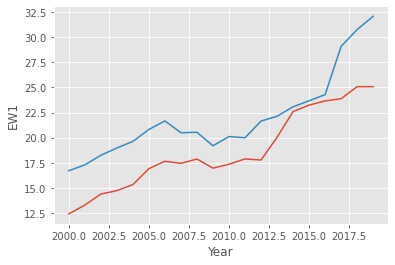

In [5]:
sns.lineplot(data=y['EW1'].loc['HUN'])
sns.lineplot(data=res['EW1'].loc['HUN'])

<AxesSubplot:xlabel='Year', ylabel='EW2'>

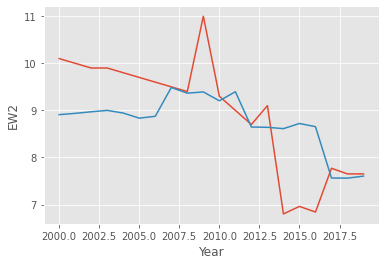

In [6]:
sns.lineplot(data=y['EW2'].loc['HUN'])
sns.lineplot(data=res['EW2'].loc['HUN'])

## Scenario

In [7]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from ggmodel.projection import *

In [8]:
def run_water_projection(data_dict):

    projection_dict = {
        'IGVA': lambda x: apply_Holt_projection(x),
        'SGVA': lambda x: apply_Holt_projection(x),
        'AGVA': lambda x: apply_Holt_projection(x),
        'GDPC': lambda x: apply_Holt_projection(x),
        'Pop': lambda x: apply_Holt_projection(x),
        'AIR': lambda x: apply_annual_rate_projection(x, rate=1.01),
        'CL': lambda x: apply_annual_rate_projection(x, rate=1.01),
        'Arice': lambda x: apply_annual_rate_projection(x, rate=1.01),
        'ETo': lambda x: apply_ffill_projection(x),
        'ETa': lambda x: apply_ffill_projection(x),
        'IRWR': lambda x: apply_ffill_projection(x),
        'ERWR': lambda x: apply_ffill_projection(x),
        'IWU': lambda x: apply_ffill_projection(x),
        'DW': lambda x: apply_ffill_projection(x),
        'TW': lambda x: apply_ffill_projection(x),
        'EFR': lambda x: apply_ffill_projection(x),
     }

    return run_projection(projection_dict, data_dict)


def run_water_scenario(data_dict, WP_rate=1.05, WRR_rate=1.01):

    data_dict = data_dict.copy()

    projection_dict = {
        'WP': lambda x: apply_annual_rate_projection(x, WP_rate),
        'WRR': lambda x: apply_annual_rate_projection(x, WRR_rate),
    }

    data_dict = run_projection(projection_dict, data_dict)

    results = EW_model.run(data_dict)

    return results

In [9]:
ISO_data_dict = {k: v.loc[['FRA'], :] for k, v in data_dict.items()}

proj_ISO_data_dict = run_water_projection(ISO_data_dict)

s_1 = run_water_scenario(proj_ISO_data_dict, WP_rate=1.05, WRR_rate=1.01)
s_2 = run_water_scenario(proj_ISO_data_dict, WP_rate=1.1, WRR_rate=1.01)
s_3 = run_water_scenario(proj_ISO_data_dict, WP_rate=0.9, WRR_rate=1.01)

/home/simon/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/home/simon/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/home/simon/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/home/simon/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/home/simon/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


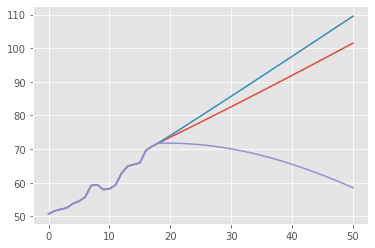

In [10]:
plt.plot(s_1['EW1'].values)
plt.plot(s_2['EW1'].values)
plt.plot(s_3['EW1'].values)

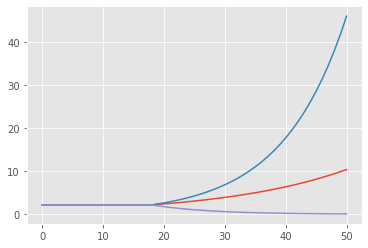

In [11]:
plt.plot(s_1['WP'].values)
plt.plot(s_2['WP'].values)
plt.plot(s_3['WP'].values)